In [1]:
#in the name of god

In [2]:
import pandas as pd 
import numpy as np
from IPython.display import clear_output
import time
import pickle

import matplotlib.pyplot as plt
from matplotlib.cbook import flatten
import matplotlib.cm as cm
import matplotlib as matplotlib

from fastdtw import fastdtw

def color_map_color(value, cmap_name='coolwarm', vmin=0, vmax=10):
    # norm = plt.Normalize(vmin, vmax)
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap(cmap_name)  # PiYG
    rgb = cmap(norm(abs(value)))[:3]  # will return rgba, we take only first 3 so we get rgb
    color = matplotlib.colors.rgb2hex(rgb)
    return color
cl=['r','g','b','c','m','y','k']
color=dict()
for i,el in enumerate(cl):
    color.update({i:el})
#extract the labels for clutering precision its for after clustering
def time_convertor(x):
    s,h,m=0,0,0
    s=round(x%60,2)
    m=int(x/60)
    h=int(m/60)
    m=m%60
    time=str(h)+':'+str(m)+':'+str(s)
    return pd.to_datetime('1970-01-01 '+time)


# Display figures inline in Jupyter notebook
import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(15, 5)})

In [3]:
with open("..\\normalized_data.txt", "rb") as fp:
        dfRaw = pickle.load(fp)
        
def get_label(number,df):
    label_event_lenght=dict()
    df=pd.read_csv(f'..\\{number}\\groundTruth.csv')
    df['length']=df.en-df.st
    for event , dft in df.groupby('evento'):
        if (event in label_event_lenght):
            label_event_lenght.update({event : label_event_lenght[event]+list(dft.length) })
        else:
            label_event_lenght.update({event : list(dft.length)})

    df['st_time']=df.apply(lambda x:time_convertor(x.st) ,axis=1 )
    df['en_time']=df.apply(lambda x:time_convertor(x.en) ,axis=1 )
    df=df.drop('st',1).drop('en',1).drop('length',1)
    evented_label=list()
    for i in range(len(df)):
        evented_label.append((df.iloc[i][0],df.iloc[i][1],df.iloc[i][2]))
    eve=pd.DataFrame(evented_label)
    eve[3]=[f'evented_label_{number}' for x in evented_label]
    return eve
Ev=[get_label(dfRaw[x][0],dfRaw[x][1]) for x in range(len(dfRaw))]
evented_label_All=pd.concat(Ev).reset_index().drop('index',1)

window={226:['curva_direita_agressiva','curva_esquerda_agressiva','aceleracao_agressiva'],
        126:['troca_faixa_direita_agressiva','troca_faixa_esquerda_agressiva'],
        186:['freada_agressiva']
       }

#remove gyto data
df_acc=[]
for num,df in dfRaw:
    df_acc.append((num,df.drop(columns=['g-x', 'g-y','g-z'])))
dfRaw=df_acc.copy()

In [4]:
#Dont RUN this part
#we should optimize M
#lengh of random event
import random
random.seed(123)
def TempEvent_genarator(df,L,i):
    temp_event=list()
    pointer=0
    stop=False
    #go on timeserise for event extraction
    while stop!=True:
        M=round(random.gauss(0.05,0.1)*L)
        clear_output(wait=True)
        pointer=pointer + M
        l_min=pointer-int(L/2)
        l_max=pointer+int(L/2)
        if l_max<0:
            l_max=L/2
        if (l_min<0):
            l_min=0
        if (l_max>len(df)):
            l_max=len(df)
            stop=True
        print('extraction ',l_max/len(df),' % of ',i,' is complete')
        temp_event.append(df[int(l_min):int(l_max)])
    return temp_event

temp_event=list()
for l,DF in enumerate([x[1] for x in dfRaw]):
    te=list()
    for i,lw in enumerate(window):
        te.append((window[lw],TempEvent_genarator(DF,lw,i+1)))
    temp_event.append(te)

with open("temp_event_new_005N03.txt", "wb") as fp:
    pickle.dump(temp_event, fp)

extraction  1.0  % of  3  is complete


In [5]:
with open("temp_event_new_005N03.txt", "rb") as fp:
        temp_event = pickle.load(fp)

def has_overlap(A_start, A_end, B_start, B_end):
    latest_start = max(A_start, B_start)
    earliest_end = min(A_end, B_end)
    return latest_start <= earliest_end

def export_labels(tempevent,evented_label):
    EvL=pd.DataFrame(evented_label)
    Labels={
          226:[],
          126:[],
          186:[],
           }
    for i,wind in enumerate(Labels):
        label=['NAG' for x in tempevent[i][1]]
        for name in tempevent[i][0]:
            el=[(x[1],x[2]) for x in EvL.iloc if x[0]==name]
            for j,te in enumerate(tempevent[i][1]):
                    if len(te)!=0:
                        sta =te.index[0]
                        ena =te.index[-1]
                        for stb,enb in el:
                            if has_overlap(sta,ena,stb,enb):
                                label[j]=name
                    else:
                        label[j]="NA"
                        
        Labels[wind]=label
    return Labels


Data={
      226:[],
      126:[],
      186:[],
       }
for i,temp in enumerate(temp_event):
    TempEv={
              226:[ x for x in temp_event[i][0][1] ],
              126:[ x for x in temp_event[i][1][1] ],
              186:[ x for x in temp_event[i][2][1] ],
               }
    Label=export_labels(temp_event[i],Ev[i])
    #merge together
    for wind in Data:
        for j in range(len(TempEv[wind])):
            Lb=Label[wind][j]
            if Lb != 'NA':
                Data[wind].append((Lb,TempEv[wind][j]))


In [6]:
#dont run this part
#calculate dist of Data from labdeled event
t1=time.time()

k,n=0,0
num_event=dict(evented_label_All.groupby(0).size())
for lenght in window:
    for name in window[lenght]:
        k=k+len(Data[lenght])*num_event[name]

Data_DS={
      226:[],
      126:[],
      186:[],
       }

for wind in Data:
    for label,event in Data[wind]:
         #---------for each Data-distance from events----------
        Y=list()
        for from_event,dfe in evented_label_All.groupby(0):
            if from_event in window[wind]:
                X=list()
                #____for each event_distance from each label_____
                for el in dfe.iloc:
                    clear_output(wait=True)
                    n=n+1
                    print('disstance calculatoin ',round((n/k)*100,4),' %  is complete')
                    if   el[3]=='evented_label_16':
                        X.append(fastdtw(event,dfRaw[0][1][el[1]:el[2]])[0])
                    elif el[3]=='evented_label_17':
                        X.append(fastdtw(event,dfRaw[1][1][el[1]:el[2]])[0])
                    elif el[3]=='evented_label_20':
                        X.append(fastdtw(event,dfRaw[2][1][el[1]:el[2]])[0])
                    elif el[3]=='evented_label_21':
                        X.append(fastdtw(event,dfRaw[3][1][el[1]:el[2]])[0])
                #_________________________________________________
                Y.append((from_event,X))
        Data_DS[wind].append((label,Y))
        #------------------------------------------------------
with open("Disstance_new_005N03.txt", "wb") as fp:
    pickle.dump(Data_DS, fp)
t2=time.time()
print(round((t2-t1)/60) ,'min has time for calculaton distant')

disstance calculatoin  100.0  %  is complete
1195 min has time for calculaton distant


In [7]:
with open("Disstance_new_005N03.txt", "rb") as fp:
        Data_DS = pickle.load(fp)

#prepare dataset for labeling
TrainData=dict()
for win in Data_DS:
    x=Data_DS[win]
    dumy_list=list()
    for events in x:
        dumy_dict=dict()
        dumy_dict.update({'label':events[0]})
        for name , event in events[1]:
            for tag,number in enumerate(event):
                dumy_dict.update({name+str(tag):number})
        dumy_list.append(dumy_dict)
    TrainData.update({win:pd.DataFrame(dumy_list)})

In [8]:
#dont run this part
from copy import deepcopy
import six
import sys
sys.modules['sklearn.externals.six'] = six
from id3 import Id3Estimator, export_text
from sklearn.metrics import accuracy_score, classification_report,precision_recall_fscore_support
from sklearn.model_selection import train_test_split

t1=time.time()
n,k=0,19*5*3

Result={
      226:[],
      126:[],
      186:[],
       }
for wid in Result:
    data=TrainData[wid].drop('label',1)
    label=TrainData[wid].label
    X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.3, random_state=123)
    for Max_depth in range(1,20):
        estimator = Id3Estimator(max_depth=Max_depth, min_samples_split=1, prune=True,
                        gain_ratio=True, min_entropy_decrease=0, is_repeating=True)
        #run it in itaraion for the best trees
        NUMBER_OF_TEST=5
        temp=list()
        for NT in range(NUMBER_OF_TEST):
            clear_output(wait=True)
            n=n+1
            print('disstance calculatoin ',round((n/k)*100,4),' %  is complete')
            estimator.fit(X_train,y_train , check_input=True)
            ACC=precision_recall_fscore_support(y_train, estimator.predict(X_train),average='macro')[2]
            temp.append((ACC,deepcopy(estimator)))
        temp_index=[(x[0],i) for i,x in enumerate(temp)]
        temp_index.sort()
        Acc=temp[temp_index[-1][1]][0]
        estimator=temp[temp_index[-1][1]][1]
        Result[wid].append(((X_train, X_test, y_train, y_test),deepcopy(estimator)))

with open("Model_new_005N03.txt", "wb") as fp:
    pickle.dump(Result, fp)
t2=time.time()
print(round((t2-t1)/60) ,'min has time for calculaton Model')

disstance calculatoin  100.0  %  is complete
378 min has time for calculaton Model


In [6]:
#dont run this part
from copy import deepcopy
import six
import sys
sys.modules['sklearn.externals.six'] = six
from id3 import Id3Estimator, export_text
from sklearn.metrics import accuracy_score, classification_report,precision_recall_fscore_support
from sklearn.model_selection import train_test_split

with open("Model_new_005N03.txt", "rb") as fp:
        Result = pickle.load(fp)

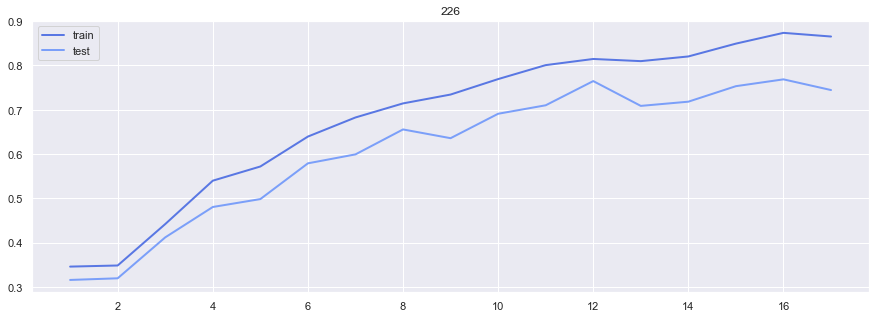

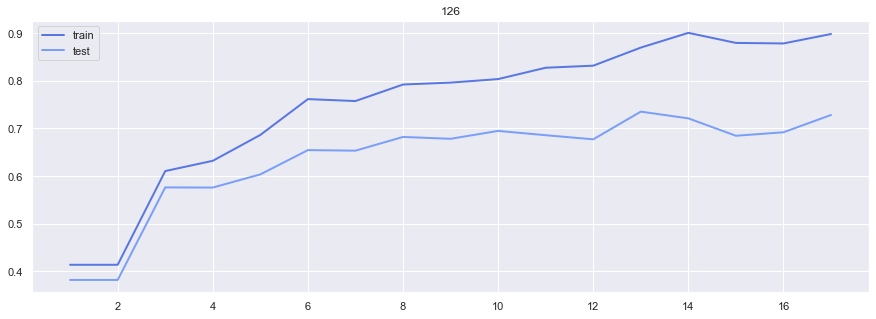

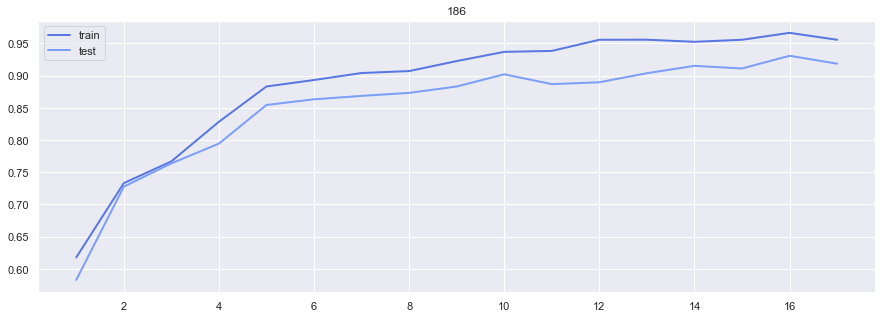

In [9]:
import warnings
warnings.filterwarnings('ignore')
for wid in window:
    X=range(1,18)
    Y=['train','test']
    test,train=[],[]
    for max_depth in X:
        es=Result[wid][max_depth-1][1]
        X_tr, X_te, y_tr, y_te=Result[wid][max_depth-1][0]
        train.append(precision_recall_fscore_support(y_tr, es.predict(X_tr),average='macro')[2])
        test.append(precision_recall_fscore_support(y_te, es.predict(X_te),average='macro')[2])

    fig, ax = plt.subplots()
    for Lambda,chart in enumerate([train,test]):
        ax.plot(X,chart, linestyle='-', linewidth=2,c=color_map_color(Lambda+1),label=str(Y[Lambda]))
    ax.set_title(wid)
    ax.legend();
    plt.show() 

In [10]:
Max_depth ={226:12,
            126:13,
            186:10,}


for wid in Max_depth:
    X_tr, X_te, y_tr, y_te=Result[wid][max_depth-1][0]
    print('-----------------------------------------------------------------')
    print(f' -------------------------window is {wid}-------------------------')
    print('-----------------------------------------------------------------')
    max_depth=Max_depth[wid]
    es=Result[wid][max_depth-1][1]
    print(classification_report(y_te, es.predict(X_te)))
    

-----------------------------------------------------------------
 -------------------------window is 226-------------------------
-----------------------------------------------------------------
                          precision    recall  f1-score   support

                     NAG       0.96      1.00      0.98      3736
    aceleracao_agressiva       0.87      0.37      0.52       128
 curva_direita_agressiva       0.94      0.73      0.83        90
curva_esquerda_agressiva       0.89      0.63      0.74        98

                accuracy                           0.96      4052
               macro avg       0.92      0.68      0.76      4052
            weighted avg       0.96      0.96      0.96      4052

-----------------------------------------------------------------
 -------------------------window is 126-------------------------
-----------------------------------------------------------------
                                precision    recall  f1-score   support

  

In [10]:
Model={}
for wid in Max_depth:
    data=TrainData[wid].drop('label',1)
    label=TrainData[wid].label
    estimator = Id3Estimator(max_depth=Max_depth[wid], min_samples_split=1, prune=True,
                    gain_ratio=True, min_entropy_decrease=0, is_repeating=True)
    #run it in itaraion for the best trees
    NUMBER_OF_TEST=50
    temp=list()
    for NT in range(NUMBER_OF_TEST):
        estimator.fit(data,label , check_input=True)
        ACC=precision_recall_fscore_support(label, estimator.predict(data),average='macro')[2]
        temp.append((ACC,deepcopy(estimator)))
    temp_index=[(x[0],i) for i,x in enumerate(temp)]
    temp_index.sort()
    Acc=temp[temp_index[-1][1]][0]
    estimator=temp[temp_index[-1][1]][1]
    Model[wid]=(deepcopy(estimator),Max_depth[wid])

for wid in Model:
    data=TrainData[wid].drop('label',1)
    label=TrainData[wid].label
    print('----------------------------------------------------')
    print(f'-----------------------window is {wid}----------------')
    print('----------------------------------------------------')
    
    print(classification_report(label, Model[wid][0].predict(data)))

with open("Model_005N03.txt", "wb") as fp:
    pickle.dump(Model, fp)

----------------------------------------------------
-----------------------window is 226----------------
----------------------------------------------------
                          precision    recall  f1-score   support

                     NAG       0.98      1.00      0.99     12357
    aceleracao_agressiva       0.95      0.71      0.81       462
 curva_direita_agressiva       0.98      0.94      0.96       333
curva_esquerda_agressiva       0.96      0.88      0.92       353

                accuracy                           0.98     13505
               macro avg       0.97      0.88      0.92     13505
            weighted avg       0.98      0.98      0.98     13505

----------------------------------------------------
-----------------------window is 126----------------
----------------------------------------------------
                                precision    recall  f1-score   support

                           NAG       0.99      1.00      1.00     24276
 troca